___
# Ciência dos Dados - PROJETO 2

___
## Nomes:  Gabriel Couto, Gabriel Miras e Mariana Abrantes
___

___

## 1. Problema

O Classificador Naive-Bayes, o qual se baseia no uso do teorema de Bayes, é largamente utilizado em filtros anti-spam de e-mails. O classificador permite calcular qual a probabilidade de uma mensagem ser SPAM considerando as palavras em seu conteúdo e, de forma complementar, permite calcular a probabilidade de uma mensagem ser HAM dada as palavras descritas na mensagem.

Para realizar o MVP (minimum viable product) do projeto, você precisa programar uma versão do classificador que "aprende" o que é uma mensagem SPAM considerando uma base de treinamento e comparar o desempenho dos resultados com uma base de testes. 


___
## 2. Separação da base de dados em Treinamento e Teste

A base de dados deve ser separada em duas partes, aleatoriamente, considerando: 
    
    75% dos dados para a parte Treinamento; e
    25% dos dados para a parte Teste.

In [55]:
import pandas as pd
import os
import random
import numpy as np
import re
import time
from random import randint

In [2]:
#Carregar dados:
leitura = pd.ExcelFile('spamham2019(1).xlsx')
dados = pd.read_excel(leitura)

In [3]:
#SEPARAR EM TREINO E TESTE
treinoOrig=dados.sample(frac=0.75,random_state=200)
testeOrig=dados.drop(treinoOrig.index)

#Cria índices numéricos pros dataframes
treinoOrig.index = range(len(treinoOrig))
testeOrig.index = range(len(testeOrig))

#  Limpando a base de dados

#### 1) Para usar o mesmo filtro no teste e no treino criamos a função limparDados

In [4]:
def limparDados(df):   
    #Cria uma cópia do dataframe pra não adulterar os originais
    dfLimpo = df.copy(deep=True)
    
    #Pega cada linha de df:
    for numLinha in range(len(dfLimpo)):
        linha = dfLimpo.loc[numLinha,'Email'].lower() #Linha com tudo em minúsculo
        
        #Subtitui caracteres que não forem letras ou espaços por espaços:
        linhaL = re.sub(r"[^a-z ]",' ',linha)
        
        palavrasFiltradas=[]
        #Para cada palavra da linha de df:
        for palavra in linhaL.split(' '):
            palavraLimpa = re.sub(r"[^a-z]",'',palavra)
            
            #Se a palavra tiver mais que 1 caractere:
            if len(palavraLimpa) > 1:
                palavrasFiltradas.append(palavraLimpa)

        #Transformando em linha de novo
        linhaLimpa = " ".join(palavrasFiltradas)
        dfLimpo.loc[numLinha,'Email'] = linhaLimpa

    return(dfLimpo)

teste = limparDados(testeOrig)
treino = limparDados(treinoOrig)

##### 2) Criar tabela de frequências de cada palavra:
Dicionario tabela de frequências:<br>
&emsp; A &emsp; = nº de vezes que determinada palavra aparece em email Ham <br>
&emsp; B &emsp; = nº de vezes que determinada palavra aparece em email Spam <br>
&emsp; pPiA = P(P∩A) = prob de determinada palavra aparecer num email Ham <br>
&emsp; pPiB = P(P∩B) = prob de determinada palavra aparecer num email spam <br>
&emsp; pPcA = P(P|A) = prob de determinada palavra aparecer dado que o email é Ham <br>
&emsp; pPcB = P(P|B) = prob de determinada palavra aparecer dado que o email é Spam <br>

In [59]:
freq = {} #Tabela de frequências 

for numLinha in range(len(treino.Email)): 
    palavras_linha = treino.loc[numLinha,'Email'].split(' ')

    for palavra in palavras_linha:
        if palavra not in freq:
            freq[palavra] = {'A':0,'B':0,'pPiA':0,'pPiB':0,'pPcA':0,'pPcB':0}
        if treino.loc[numLinha,'Class'] == 'ham':
            freq[palavra]['A'] +=1 #A é ham
        else:
            freq[palavra]['B'] +=1

pA = (len(dados[dados.Class=='ham']))/(len(dados))
pB = (len(dados[dados.Class=='spam']))/(len(dados))
palavrasA,palavrasB = 0,0

for key,valor in freq.items():  
    palavrasA += valor['A']
    palavrasB += valor['B']
totalPalavras = palavrasA + palavrasB
palavrasDistintas = len(freq)


for palavra,valor in freq.items():
    #Prob de determinada palavra aparecer:
    freq[palavra]['pP'] = (valor['A']+valor['B'])/(totalPalavras)
    
    freq[palavra]['pPcA'] = (valor['A']+1)/(palavrasA+palavrasDistintas) #Laplace Smoothing
    freq[palavra]['pPcB'] = (valor['B']+1)/(palavrasB+palavrasDistintas) #Laplace Smoothing
        
    freq[palavra]['pPiA'] = freq[palavra]['pPcA']*pA
    freq[palavra]['pPiB'] = freq[palavra]['pPcB']*pB
    
# Transformando a tabela num dataframe:
tabelapalavras = pd.DataFrame(freq).T
tabelapalavras.head(10)

,A,B,pP,pPcA,pPcB,pPiA,pPiB
no,228.0,57.0,0.004834,0.004238,0.003176,0.003670,0.000426
it,519.0,25.0,0.009227,0.009624,0.001424,0.008334,0.000191
not,310.0,13.0,0.005478,0.005756,0.000767,0.004984,0.000103
pride,2.0,0.0,0.000034,0.000056,0.000055,0.000048,0.000007
almost,11.0,0.0,0.000187,0.000222,0.000055,0.000192,0.000007
lt,248.0,0.0,0.004206,0.004609,0.000055,0.003991,0.000007
gt,249.0,0.0,0.004223,0.004627,0.000055,0.004007,0.000007
years,18.0,6.0,0.000407,0.000352,0.000383,0.000305,0.000051
old,13.0,2.0,0.000254,0.000259,0.000164,0.000224,0.000022
and,667.0,88.0,0.012805,0.012364,0.004874,0.010706,0.000653


In [63]:
print('PalavrasA (com repet):',palavrasA,'| PalavrasB (com repet):',palavrasB, '| totalPalavras:',totalPalavras,' | PalavrasDistintas (sem repet):',palavrasDistintas)
print('pA:',round(pA,3),'| pB:',round(pB,3))

PalavrasA (com repet): 47365 | PalavrasB (com repet): 11595 | totalPalavras: 58960  | PalavrasDistintas (sem repet): 6665
pA: 0.866 | pB: 0.134


___
## 3. Classificador Naive-Bayes

#### 3) Classificador:

In [9]:
mensagens={}

for numLinha in range(len(teste.Email)):   
    mensagens[numLinha] = {'Email original':testeOrig.loc[numLinha,'Email'],
                           'Email Filtrado':teste.loc[numLinha,'Email'],
                           'Classe original':testeOrig.loc[numLinha,'Class'],
                            'pAcT':0,'pBcT':0,'lista pAcT':[], 'lista pBcT':[]}
    
    lAcT,lBcT=[],[]
    palavras_linha = teste.loc[numLinha,'Email'].split(' ')
    
    for palavra in palavras_linha:    
        if palavra in tabelapalavras.index:
            lAcT.append(tabelapalavras.loc[palavra,'pPcA'])
            lBcT.append(tabelapalavras.loc[palavra,'pPcB'])
        else:
            lAcT.append(1/(palavrasA +palavrasDistintas))
            lBcT.append(1/(palavrasB + palavrasDistintas))
    
    pAcT, pBcT = np.prod(lAcT) , np.prod(lBcT)

    mensagens[numLinha]['pAcT'] = pAcT*pA
    mensagens[numLinha]['pBcT'] = pBcT*pB
    mensagens[numLinha]['lista pAcT'] = lAcT
    mensagens[numLinha]['lista pBcT'] = lBcT

    if pAcT >= pBcT:
        mensagens[numLinha]['Classe calculada'] = 'ham'
    if pAcT < pBcT: 
        mensagens[numLinha]['Classe calculada'] = 'spam'

#Para melhorar a visualização dos emails colocamos ela num dataframe:
tabelaEmails = pd.DataFrame(mensagens).T
tabEmailsLimpo = tabelaEmails.loc[:,['Classe original','Classe calculada','Email original','Email Filtrado','pAcT', 'pBcT']]

a = tabelaEmails[tabelaEmails['Classe original'] != tabelaEmails['Classe calculada']].sort_values(by='pAcT',ascending=False)

tabEmailsLimpo.head()

,Classe original,Classe calculada,Email original,Email Filtrado,pAcT,pBcT
0,spam,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in wkly comp to win fa cup final tk...,3.77152e-93,4.64913e-73
1,ham,ham,Eh u remember how 2 spell his name... Yes i di...,eh remember how spell his name yes did he naug...,1.01642e-43,8.12505e-51
2,ham,ham,Fine if thatåÕs the way u feel. ThatåÕs the wa...,fine if that the way feel that the way its gota,3.89211e-30,1.82416e-39
3,ham,ham,I see the letter B on my car,see the letter on my car,7.56334e-17,6.73311e-21
4,ham,ham,Pls go ahead with watts. I just wanted to be s...,pls go ahead with watts just wanted to be sure...,1.17173e-44,2.38845e-50


In [10]:
VerHam, VerSpam, FalHam, FalSpam = 0,0,0,0
for numLinha in range(len(mensagens)):
    #Negativo Verdadeiro
    if (tabelaEmails.loc[numLinha,'Classe original'] == 'ham')&(tabelaEmails.loc[numLinha,'Classe calculada'] == 'ham'): 
        VerHam+=1
    #Positivos Verdadeiros
    if (tabelaEmails.loc[numLinha,'Classe original'] == 'spam')&(tabelaEmails.loc[numLinha,'Classe calculada'] == 'spam'):
        VerSpam+=1
    #Falso Negativo
    if (tabelaEmails.loc[numLinha,'Classe original'] == 'spam')&(tabelaEmails.loc[numLinha,'Classe calculada'] == 'ham'): 
        FalHam+=1
    #Falsos Positivos
    if (tabelaEmails.loc[numLinha,'Classe original'] == 'ham')&(tabelaEmails.loc[numLinha,'Classe calculada'] == 'spam'): 
        FalSpam+=1

#Positivo = ham | Negativo = spam 
print('Positivos Verdadeiros (Verdadeiros Spam): ',VerSpam)
print('Negativos Verdadeiros (Verdadeiros Ham): ',VerHam)
print('Falsos Positivos (Ham calculados como Spam):',FalSpam)
print('Falsos Negativos (Spam calculados como Ham): ',FalHam)
print()
print('Precisão de acerto dos Ham\'s:',round(100*VerHam/(VerHam+FalSpam),3),'%')
print('Precisão de acerto dos Spam\'s:',round(100*VerSpam/(VerSpam+FalHam),3),'%')

Positivos Verdadeiros (Verdadeiros Spam):  182
Negativos Verdadeiros (Verdadeiros Ham):  1154
Falsos Positivos (Ham calculados como Spam): 47
Falsos Negativos (Spam calculados como Ham):  10

Precisão de acerto dos Ham's: 96.087 %
Precisão de acerto dos Spam's: 94.792 %


#### Para fazermos o loop simplificamos o código ao máximo para reduzir o tempo de cada iteração:
Fazendo algumas mudanças e preferencialmente trabalhando com dicionário em vez de dataframe fazemos o tempo de cada iteração cair de 0.4s para 0.06s.

In [42]:
dados0 = pd.read_excel('spamham2019(1).xlsx')
dadosz = limparDados(dados0)
resultados=[]

n = 10000

start = time.time()
for j in range(n):
    treinoOrigz=dadosz.sample(frac=0.75,random_state=randint(0,100000))
    testeOrigz=dadosz.drop(treinoOrigz.index)

    #Criar índices:
    treinoOrigz.index = range(len(treinoOrigz))
    testeOrigz.index = range(len(testeOrigz))

    testez, treinoz = testeOrigz.copy(deep=True), treinoOrigz.copy(deep=True)

    freq = {} #Tabela de frequências 

    pA = (len(treinoz[treinoz.Class=='ham']))/(len(treinoz))
    pB = (len(treinoz[treinoz.Class=='spam']))/(len(treinoz))

    
    
    ###### FREQUÊNCIAS DAS PALAVRAS ######
    
    #Para reduzirmos o tempo de execução transformamos o dataframe num dicionário
    dicionas=treinoz.to_dict()
    
    for numLinha in range(len(treinoz)): 

        for palavra in dicionas['Email'][numLinha].split(' '):
            if palavra not in freq:
                freq[palavra] = {'A':0,'B':0,'pPcA':0,'pPcB':0}
            if dicionas['Class'][numLinha] == 'ham':
                freq[palavra]['A'] +=1 #A é ham
            else:
                freq[palavra]['B'] +=1

    #Contagens:       
    palavrasA,palavrasB = 0,0
    for key,valor in freq.items():  
        palavrasA += valor['A']
        palavrasB += valor['B']

    for palavra,valor in freq.items():   
        freq[palavra]['pPcA'] = (valor['A']+1)/(palavrasA+len(freq)) #Laplace Smoothing
        freq[palavra]['pPcB'] = (valor['B']+1)/(palavrasB+len(freq)) #len(freq) = Nº palavras distintas


    ###### CLASSIFICADOR ######

    mensagens={}
    
    for numLinha in range(len(testez)):   
        mensagens[numLinha] = {'Classe original':testeOrigz.loc[numLinha,'Class'],'pAcT':0,'pBcT':0}

        pAcT,pBcT=1,1
        for palavra in testez.loc[numLinha,'Email'].split(' '):    
            if palavra in freq.keys():
                pAcT*= freq[palavra]['pPcA'] 
                pBcT*= freq[palavra]['pPcB'] 
            else:
                pAcT*= 1/(palavrasA +len(freq))
                pBcT*= 1/(palavrasB + len(freq))

        mensagens[numLinha]['pAcT'] = pAcT*pA
        mensagens[numLinha]['pBcT'] = pBcT*pB

        if pAcT >= pBcT:
            mensagens[numLinha]['Classe calculada'] = 'ham'
        if pAcT < pBcT: 
            mensagens[numLinha]['Classe calculada'] = 'spam'

    acertos = 0 
    for k in range(len(mensagens)):
        if mensagens[k]['Classe original'] == mensagens[k]['Classe calculada']:
            acertos+=1

    resultados.append(round(100*acertos/len(mensagens),3))
    j+=1
    
    
end = time.time()
print("Tempo médio por iteração:",(end-start)/n,' Tempo total:',(end-start))

Tempo médio por iteração: 0.06614953844547272  Tempo total: 661.4953844547272


##### Plotamos o histograma dos 10 mil resultados:

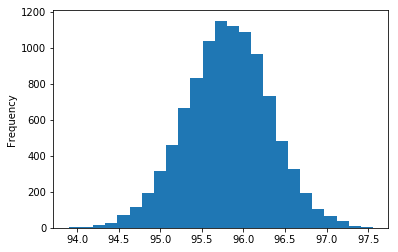

In [54]:
sResult= pd.Series(data=resultados)
sResult.plot.hist(bins=25)

Obtemos uma curva normal.